In [1]:

import os                                    # system functions
import yaml
import nipype.interfaces.spm as spm          # spm
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio           # Data i/o
import nipype.interfaces.fsl as fsl          # fsl
import nipype.pipeline.engine as pe          # pypeline engine
import nipype.algorithms.modelgen as model   # model generation
from CPAC.registration import create_wf_apply_ants_warp
from nipype.workflows.fmri.fsl import (create_featreg_preproc,
                                       create_modelfit_workflow,
                                       create_reg_workflow)
from pandas import read_csv

In [21]:
! git pull

remote: Counting objects: 4, done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/jordanmuraskin/CCD-scripts
   7f01bf5..8c0188c  master     -> origin/master
Updating 7f01bf5..8c0188c
Fast-forward
 analysis/PPI.csv | 818 +++++++++++++++++++++++++++----------------------------
 1 file changed, 409 insertions(+), 409 deletions(-)


In [3]:
regressors=read_csv('PPI.csv',sep=',',header=0)
workflow = pe.Workflow(name='PPI', base_dir='./')
regressors

,Stim,Stim_Deriv,Cont,Cont_Deriv
0,-0.142024,-0.032669,-0.557605,0.010213
1,-0.174692,-0.032151,-0.544622,0.011211
2,-0.206323,-0.031055,-0.529641,0.013061
3,-0.236797,-0.029969,-0.512959,0.014584
4,-0.266257,-0.029021,-0.494933,0.015807
5,-0.294835,-0.028179,-0.475803,0.016847
6,-0.322610,-0.027395,-0.455697,0.017785
7,-0.349621,-0.026641,-0.434690,0.018661
8,-0.375888,-0.025900,-0.412833,0.019487
9,-0.401416,-0.025164,-0.390174,0.020262


In [155]:
modelspec=pe.Node(interface=model.SpecifyModel(),name="modelspec")

In [156]:
subject_id='CCD012'

drFileLocation='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1'

GroupDF=[]
numberOfICs=10
columnNames=[]
for rsnNumber in range(numberOfICs):
    columnNames.append('RSN%d' % rsnNumber)


filterOn=False
zscoreOn=True
lowpass=0.1
globalNR=0
data=['/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_1/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % subject_id]
#load DMN_network
drFilePath = '%s/%s_data_/spatial_map_timeseries_for_DR/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global%d.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/spatial_map_timeseries.txt' % (drFileLocation,subject_id,1,globalNR)
df = read_csv(drFilePath,header=None,names=columnNames,delim_whitespace=True)
df['Subject_ID'] = subject_id
# df['Subject'] = indx
df.index.name = 'TR'
df.reset_index(level=0,inplace=True)
#modelspec
TR = 2
##  moral dilemma
modelspec.inputs.input_units = 'secs'
modelspec.inputs.time_repetition = TR
modelspec.inputs.high_pass_filter_cutoff = 100
modelspec.inputs.functional_runs=data

r=1
from pandas import read_csv
from nipype.interfaces.base import Bunch
Order1_onsets = [22,150,248,406,564,662]
Order1_durations = [30,60,90,60,30,90]
Order2_onsets = [56,214,342,470,598,756]
Order2_durations = [90,30,60,90,60,30]
        # button_onsets = [52,144,206,238,330,392,454,546,578,640,732]
        # button_duration =[2]
        #Make subject specific EVs given feedback ordering
info=[]
regressor_names=list(regressors.keys().values)
regressor_values=list(regressors.values.transpose().tolist())
phys=list(df['RSN3'])
PPI=list(regressors['Cont']*df['RSN3'])
regressor_names+=['PHYS','PPI']
regressor_values.append(list(df['RSN3']))
regressor_values.append(PPI)

SubjInfo = read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/NARSAD_stimulus_JM.csv')
SubjInfo.set_index('JM_INTERNAL',inplace=True)
if r==0:
    paradigmType=SubjInfo.loc[subject_id]['SCAN_1_PARADIGM']
else:
    paradigmType=SubjInfo.loc[subject_id]['SCAN_2_PARADIGM']
if paradigmType==0 or paradigmType == 2:
    focus_onset = Order2_onsets
    focus_durations = Order2_durations
    wander_onset = Order1_onsets
    wander_durations = Order1_durations
elif paradigmType==1 or paradigmType == 3:
    focus_onset = Order1_onsets
    focus_durations = Order1_durations
    wander_onset = Order2_onsets
    wander_durations = Order2_durations
info.insert(0,Bunch(regressor_names=regressor_names,regressors=regressor_values))
modelspec.inputs.subject_info=info

In [152]:
regressor_values

[[-0.1420239,
  -0.17469160000000003,
  -0.20632270000000003,
  -0.2367971,
  -0.2662565,
  -0.2948349,
  -0.3226098,
  -0.34962129999999997,
  -0.3758878,
  -0.4014164,
  -0.4262103,
  -0.4494674,
  -0.3699327,
  -0.03019373,
  0.32434070000000004,
  0.5191553,
  0.5769948,
  0.5598875,
  0.5109149000000001,
  0.45563190000000003,
  0.4071794,
  0.36948109999999995,
  0.3411927,
  0.3193317,
  0.3012935,
  0.285407,
  0.26997350000000003,
  0.15331129999999998,
  -0.22137600000000002,
  -0.507499,
  -0.3731751,
  -0.08657747,
  0.115754,
  0.2134781,
  0.24303690000000003,
  0.23434179999999996,
  0.2090089,
  0.181513,
  0.15875060000000002,
  0.14197200000000001,
  0.12985439999999998,
  0.1206736,
  0.1131663,
  0.1066096,
  0.10064110000000001,
  0.09510861,
  0.08995043,
  0.0851236,
  0.08062078,
  0.0764713,
  0.07266005,
  0.0691191,
  0.06581092,
  0.06273117,
  0.05988078,
  0.05725748,
  0.05485597,
  0.05266849,
  0.05068556,
  0.04889678,
  0.04729174,
  0.04586032,
  0.0

In [157]:
modelfit = create_modelfit_workflow(name='PPI_modelfit')
modelfit.inputs.inputspec.interscan_interval = TR
modelfit.inputs.inputspec.model_serial_correlations = True
modelfit.inputs.inputspec.bases = {'dgamma':{'derivs':False}}
cont1 = ['Focus>Wander','T', ['Cont'],[1]]
modelfit.inputs.inputspec.contrasts = [cont1]

workflow.connect(modelspec, 'session_info', modelfit, 'inputspec.session_info')
workflow.run()

160822-14:07:10,815 workflow INFO:
	 ['check', 'execution', 'logging']
160822-14:07:10,849 workflow INFO:
	 Running serially.
160822-14:07:10,852 workflow INFO:
	 Executing node modelspec in dir: /home/jmuraskin/Projects/CCD/CCD-scripts/analysis/PPI/modelspec
160822-14:07:11,663 workflow INFO:
	 Runtime memory and threads stats unavailable
160822-14:07:11,858 workflow INFO:
	 Executing node level1design in dir: /home/jmuraskin/Projects/CCD/CCD-scripts/analysis/PPI/PPI_modelfit/level1design
160822-14:07:12,621 workflow INFO:
	 Runtime memory and threads stats unavailable
160822-14:07:12,848 workflow INFO:
	 Executing node modelgen in dir: /home/jmuraskin/Projects/CCD/CCD-scripts/analysis/PPI/PPI_modelfit/modelgen
160822-14:07:12,868 workflow INFO:
	 Executing node _modelgen0 in dir: /home/jmuraskin/Projects/CCD/CCD-scripts/analysis/PPI/PPI_modelfit/modelgen/mapflow/_modelgen0
160822-14:07:12,885 workflow INFO:
	 Running: feat_model run0 
160822-14:07:14,618 workflow INFO:
	 Executing no

RuntimeError: Workflow did not execute cleanly. Check log for details

NameError: name 'Level1Design' is not defined

Populating the interactive namespace from numpy and matplotlib


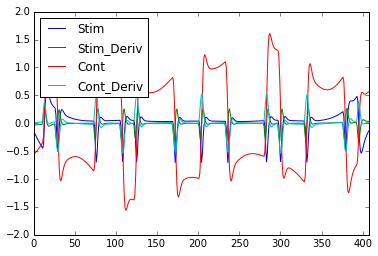

In [26]:
%pylab inline
regressors.plot()

In [34]:
list(regressors.keys().values)

['Stim', 'Stim_Deriv', 'Cont', 'Cont_Deriv']